# <center> Predict future sales - 1C company </center>
### [1. Basic inspection of data](#1)
### [2. EDA + raw data feat. eng.](#2)
### [3. Mean encoding of categorical data](#3)
### [4. Lags on aggregated data](#4)
### [5. XGB + LGB benchmarks](#5)

In [1]:
import os
import pickle
import time
import gc

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline 
import seaborn as sns
sns.set()

from itertools import product
from tqdm import tqdm_notebook

from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split, ShuffleSplit

from xgboost import XGBRegressor
from xgboost import plot_importance

import lightgbm as lgb
from lightgbm import LGBMRegressor

# Credit : https://www.kaggle.com/anqitu/feature-engineer-and-model-ensemble-top-10
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [2]:
DATA_FOLDER = './readonly/final_project_data/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

test           = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

# 1. Datasets<a id='1'></a>

In [3]:
# drop duplicates
transactions.drop_duplicates(inplace=True)
item_categories.drop_duplicates(inplace=True)
items.drop_duplicates(inplace=True)
shops.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

# drop outlier with highest price
transactions = transactions.loc[transactions.item_price != 307980]

# switch price and count for outlier item with huge count
transactions.at[2909818, 'item_cnt_day'] = 1
transactions.at[2909818, 'item_price'] = 2169.0

test['date_block_num'] = pd.Series([34 for _ in range(len(test))])

# items in test set not in training set
items_not_in_train = list(set(test['item_id']) - (set(transactions['item_id'])))

# 2. Monthly aggregated data<a id='2'></a>
[2.1 total sales for ea. shop__](#21)[2.2. Total sales for ea. item, shop-wide__](#22) [2.3. monthly sales per category__](#23) [2.4. Prices__](#24)


In [4]:
# extend transactions dataset with all existing (date_block_num, shop_id, item_id) triples
transactions_extended = pd.DataFrame()
for date_block_num in tqdm_notebook(range(transactions['date_block_num'].nunique())):
    transactions_extended = transactions_extended.append(pd.DataFrame((\
    list(product([date_block_num], transactions.loc[transactions['date_block_num'] == date_block_num]['shop_id'].unique(),\
                 transactions.loc[transactions['date_block_num'] == date_block_num]['item_id'].unique())))), \
                                                        ignore_index=True)

transactions_extended.columns = ['date_block_num', 'shop_id', 'item_id']

# monthly aggregation
transactions_monthly = transactions.groupby(['date_block_num', 'shop_id', 'item_id'], as_index = False) \
    .agg({'item_cnt_day' : 'sum'}).rename(columns={'item_cnt_day': 'item_cnt_month'})
                                                                # as_index=False to flatten multi-indices

transactions_monthly = pd.merge(transactions_extended, transactions_monthly, on = transactions_extended.columns.tolist(), \
                                how='left').fillna(0)

# align columns of transactions_monthly and test
transactions_monthly['ID'] = -1
transactions_monthly = transactions_monthly[['ID','shop_id', 'item_id', 'date_block_num', 'item_cnt_month']]
test['item_cnt_month'] = 0

# concat transactions_monthly and test
all_data = pd.concat([transactions_monthly, test]).sort_values(by='date_block_num')

# add date info
all_data['month'] = all_data.date_block_num % 12 
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['month_num_days'] = all_data.month.map(days)
all_data['year'] = all_data.date_block_num.apply(lambda x: 2013 if (0 <= x <= 11) else 2014 if (12 <= x <= 23) else 2015)

# clip item_cnt_month
all_data.item_cnt_month = all_data.item_cnt_month.clip(0, 20)

# downcast except column 'ID'
all_data = pd.concat([all_data['ID'].astype(np.int32), downcast_dtypes(all_data.drop(columns='ID'))], axis=1)

## 2.1. total sales for ea. shop <a id='21'></a> 
[Shop sales history__](#220)
[Closed shops__](#221)
[shop duration__](#222)
[add categories](#223)

In [5]:
gb = all_data.groupby(['date_block_num', 'shop_id'], as_index = False).agg({'item_cnt_month':'sum'})\
            .rename(columns={'item_cnt_month':'item_cnt_month_shop'})

all_data = pd.merge(all_data, gb, on=['date_block_num', 'shop_id'], how='left')

#### Duplicate shops names : merge into one shop and transfer all items from duplicate shop to real one

In [6]:
print(shops.shop_name[0], shops.shop_name[57])
print(shops.shop_name[1], shops.shop_name[58])
print(shops.shop_name[10], shops.shop_name[11])

!Якутск Орджоникидзе, 56 фран Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? Жуковский ул. Чкалова 39м²


In [7]:
#rename shop 0 shop 57
df_shop0 = all_data.loc[all_data.shop_id == 0].assign(shop_id=57)
# concat dataframes from former shop 0 and shop 57
df_shop57 = pd.concat([df_shop0, all_data.loc[all_data.shop_id == 57]])

all_data = all_data[all_data.shop_id != 0]# remove rows w/ shop_id = 0
all_data = all_data[all_data.shop_id != 57]# remove rows w/ shop_id = 57
all_data = pd.concat([all_data, df_shop57]).sort_values(by='date_block_num') # merge back into df

#rename shop 1 shop 58
df_shop1 = all_data.loc[all_data.shop_id == 1].assign(shop_id=58)
# concat dataframes from former shop 1 and shop 58
df_shop58 = pd.concat([df_shop1, all_data.loc[all_data.shop_id == 58]])

all_data = all_data[all_data.shop_id != 1]# remove rows w/ shop_id = 1
all_data = all_data[all_data.shop_id != 58]# remove rows w/ shop_id = 58
all_data = pd.concat([all_data, df_shop58]).sort_values(by='date_block_num') # merge back into df

#rename shop 11 shop 10
df_shop11 = all_data.loc[all_data.shop_id == 11].assign(shop_id=10)
# concat dataframes from former shop 11 and shop 10
df_shop10 = pd.concat([df_shop11, all_data.loc[all_data.shop_id == 10]])

all_data = all_data[all_data.shop_id != 11]# remove rows w/ shop_id = 11
all_data = all_data[all_data.shop_id != 10]# remove rows w/ shop_id = 10
all_data = pd.concat([all_data, df_shop10]).sort_values(by='date_block_num') # merge back into df

#### Shop sales history<a id='220'></a>

In [8]:
# sales volume history for ea. shop
shop_cnt_per_dbn = pd.pivot_table(all_data, values='item_cnt_month_shop', columns=['date_block_num'],\
                                      index=['shop_id'], aggfunc=np.sum).fillna(0).reset_index()\
                                        .rename_axis(None, axis= 1)
shop_cnt_per_dbn.set_index('shop_id', inplace=True)

#### Closed shops<a id='221'></a>

shops not selling any items in the last n months

In [9]:
n = 3

shops_closed = shop_cnt_per_dbn.loc[shop_cnt_per_dbn.iloc[:, 33-n+1:].sum(axis=1) == 0].index.tolist()
print('shops_closed in the last ', n , ' months : ', shops_closed)
print('shops_closed in test set :', set(shops_closed) & (set(test.shop_id.unique())))

#all_data['shop_isclosed'] = all_data.shop_id.apply(lambda x: 1 if x in shops_closed else 0)

shops_closed in the last  3  months :  [8, 13, 17, 23, 27, 29, 30, 32, 33, 40, 43, 54]
shops_closed in test set : set()


#### shop duration<a id='222' ></a>

In [10]:
shop_opening_dbn = []
shop_last_dbn = []
for shop_id in tqdm_notebook(shop_cnt_per_dbn.index):
    shop_history = shop_cnt_per_dbn.loc[[shop_id],:].transpose()[shop_id].tolist()
    #index of first non zero value or 0 if nothing yielded by generator
    shop_opening_dbn.append(next((i for i, x in enumerate(shop_history) if x), 0))
    #index of last non-zero value or last index if nothing yielded by generator
    shop_last_dbn.append(len(shop_history) - next((i for i, x in enumerate(shop_history[::-1]) if x), 1) - 1)
    # https://stackoverflow.com/questions/19502378/python-find-first-instance-of-non-zero-number-in-list

In [11]:
shop_dates = pd.DataFrame({'shop_id':shop_cnt_per_dbn.index, 'shop_opening_dbn' : shop_opening_dbn, \
                                    'shop_last_dbn' : shop_last_dbn})
shop_dates['shop_duration'] = shop_dates.shop_last_dbn - shop_opening_dbn + 1
all_data = pd.merge(all_data, shop_dates, on='shop_id', how='left')

#### Add categories<a id='223' ></a>

In [12]:
shops['shop_city'] = shops.shop_name.str.split(' ').apply(lambda x:x[0])
shops['shop_city_label'] = pd.factorize(shops.shop_city)[0]

shops['shop_type'] = shops.shop_name.apply(lambda x: 'МТРЦ' if 'МТРЦ' in x[1] else 'ТРЦ' if 'ТРЦ' in x else \
                                              'ТРК' if 'ТРК' in x else 'ТЦ' if 'ТЦ' in x else 'ТК' if 'ТК' in x \
                                              else 'other')
shops['shop_type_label'] = pd.factorize(shops.shop_type)[0]

all_data = pd.merge(all_data, shops[['shop_id', 'shop_city_label', 'shop_type_label']], \
                                on='shop_id', how='left')

Frequency encodings

In [13]:
freq_mapping = all_data.groupby('shop_city_label').size()/len(all_data) 
all_data['shop_city_label_freq'] = all_data.shop_city_label.map(freq_mapping)

freq_mapping = all_data.groupby('shop_type_label').size()/len(all_data) 
all_data['shop_type_label_freq'] = all_data.shop_type_label.map(freq_mapping)


## 2.2. Total sales for ea. item, shop-wide <a id='22'></a>
[Items that were never sold__](#211)
[Outdated items__](#212')
[item release date_block_num and  last sale date_block_num, shop-wide__](#213)
[item release date_block_num and last sale date_block_num, for every shop__](#214)
[Add item_id feature interactions__](#215)
[items categories and meta-categories](#218)

In [14]:
gb = all_data.groupby(['item_id','date_block_num'], as_index = False).agg({'item_cnt_month':'sum'})\
                .rename(columns={'item_cnt_month' : 'item_cnt_month_item'})

all_data = pd.merge(all_data, gb, on=['item_id','date_block_num'], how='left')

#### Total sales history

In [15]:
# pivot table only for training set since some items from test set are not seen in training set
item_cnt_per_dbn = pd.pivot_table(all_data.loc[all_data.date_block_num < 34], values='item_cnt_month_item', columns=['date_block_num'],\
                                      index=['item_id']).fillna(0).reset_index().rename_axis(None, axis= 1)
item_cnt_per_dbn.set_index('item_id', inplace=True)

In [16]:
#items w/ zero sales
item_zero_sales = item_cnt_per_dbn.sum(axis=1).loc[item_cnt_per_dbn.sum(axis=1) == 0].index.tolist()
# = [4591, 7547, 11871, 13474, 18062]

assert set(item_zero_sales) & set( all_data.loc[all_data.date_block_num == 34].item_id.unique() ) == set()
assert all_data.loc[all_data.item_id.isin(item_zero_sales)].item_cnt_month.sum() == 0

#remove item w/ zero sales
all_data = all_data.loc[~all_data.item_id.isin(item_zero_sales)]
item_cnt_per_dbn = item_cnt_per_dbn.loc[~item_cnt_per_dbn.index.isin(item_zero_sales)]

In [17]:
# items w/ no sales for the last n months
n = 6
items_no_recent_sales = item_cnt_per_dbn[item_cnt_per_dbn.iloc[:, 33 - n+1:].sum(axis=1) == 0].index.tolist()

In [18]:
len(items_no_recent_sales)

12891

In [19]:
# 186 items w/ no recent sales are in test set
len(set(items_no_recent_sales)&set(all_data.loc[all_data.date_block_num==34].item_id.unique()))

186

#### item release date and  last sale date, shop-wide<a id='213' ></a>

In [20]:
release_dbn = []
last_sale_dbn = []
for item_id in tqdm_notebook(item_cnt_per_dbn.index):
    item_sale_history = item_cnt_per_dbn.loc[[item_id],:].transpose()[item_id].tolist()
    #index of first non zero value or 0 if nothing yielded by generator
    release_dbn.append(next((i for i, x in enumerate(item_sale_history) if x), 0))
    #index of last non-zero value or last index if nothing yielded by generator
    last_sale_dbn.append(len(item_sale_history) - next((i for i, x in enumerate(item_sale_history[::-1]) if x), 1) - 1)
    # https://stackoverflow.com/questions/19502378/python-find-first-instance-of-non-zero-number-in-list

In [21]:
item_dates_shopwide = pd.DataFrame({'item_id':item_cnt_per_dbn.index, 'item_release_dbn' : release_dbn, \
                                    'item_last_sale_dbn' : last_sale_dbn})

all_data = pd.merge(all_data, item_dates_shopwide, on='item_id', how='left')

#### item release date and last sale date, for every shop<a id='214' ></a>

In [22]:
item_cnt_per_dbn_per_shop = pd.pivot_table(all_data, values='item_cnt_month', columns=['date_block_num'],\
                                      index=['item_id', 'shop_id'], aggfunc=np.sum).fillna(0).reset_index().rename_axis(None, axis= 1)

item_cnt_per_dbn_per_shop_nonzero = item_cnt_per_dbn_per_shop.loc[item_cnt_per_dbn_per_shop.iloc[:,2:].sum(axis=1) != 0]\
        .reset_index(drop=True)

In [23]:
release_dbn_per_shop = []
last_sale_dbn_per_shop = []

with open('release_dbn_per_shop.pkl', 'rb') as f:
    release_dbn_per_shop = pickle.load(f)
with open('last_sale_dbn_per_shop.pkl', 'rb') as f:
    last_sale_dbn_per_shop = pickle.load(f)

In [24]:
item_dates_shop_level = pd.DataFrame({'item_id':item_cnt_per_dbn_per_shop_nonzero.iloc[:,0],\
              'shop_id':item_cnt_per_dbn_per_shop_nonzero.iloc[:,1],\
              'item_release_dbn_shop' : release_dbn_per_shop,\
              'item_last_sale_dbn_shop' : last_sale_dbn_per_shop})

all_data = pd.merge(all_data, item_dates_shop_level, on=['item_id','shop_id'], how='left')\
                        .fillna(0)

#### Add item_id feature interactions<a id='215' ></a>

In [25]:
# duration of item on the market and in the shop
all_data['item_market_duration'] = all_data.item_last_sale_dbn \
                                                - all_data.item_release_dbn + 1
all_data['item_shop_duration'] = all_data.item_last_sale_dbn_shop \
                                                - all_data.item_release_dbn_shop + 1
# item release and last sale date shift between shop and market
all_data['item_release_market_shift'] = all_data.item_release_dbn_shop\
                                                - all_data.item_release_dbn
all_data['item_last_sale_market_shift'] = all_data.item_last_sale_dbn_shop\
                                                - all_data.item_last_sale_dbn

## 2.3. Total sales for ea. category, shop-wide <a id='23'></a>

In [26]:
items = items.merge(item_categories, on='item_category_id')

all_data = pd.merge(all_data, items[['item_id','item_category_id']], on='item_id', how='left')

In [27]:
gb = all_data.groupby(['date_block_num', 'item_category_id'], as_index = False).agg({'item_cnt_month':'sum'})\
                .rename(columns={'item_cnt_month' : 'item_cnt_month_cat'})

all_data = pd.merge(all_data, gb, on=['date_block_num', 'item_category_id'], how='left')

#### Category total sales history

In [28]:
cat_cnt_per_dbn = pd.pivot_table(all_data, values='item_cnt_month_cat', columns=['date_block_num'],\
                                      index=['item_category_id'], aggfunc = np.sum).fillna(0).reset_index()\
                .rename_axis(None, axis= 1)#.loc[40,:].plot()
# default agg_func = np.mean
# item_id becomes the index => easier for selecting data
cat_cnt_per_dbn.set_index('item_category_id', inplace=True)

#### Categories that were never sold

In [29]:
cat_zero_sales = cat_cnt_per_dbn.sum(axis=1).loc[cat_cnt_per_dbn.sum(axis=1) == 0].index.tolist()
#print('cat_zero_sales in test set : ', cat_zero_sales in all_data.loc[all_data.date_block_num > 33].item_category_id.tolist())
cat_zero_sales

[]

#### items categories and meta-categories <a id='218'></a>

In [30]:
# = ([Кино , DVD]).str.split('-').apply(lambda x: x[0]) = 'Кино'
items['item_general_category'] = items.item_category_name.str.split('-').apply(lambda x: x[0]) 
items['item_general_category_label'] = pd.factorize(items.item_general_category)[0]

# = ([Кино , DVD]).str.split('-').apply(lambda x:x[1] if len(x)>1 else x[0]) = 'DVD' if subcat exists, else 'Кино'
items['item_sub_category'] = items.item_category_name.str.split('-').apply(lambda x:x[1] if len(x)>1 else x[0])
items['item_sub_category_label'] = pd.factorize(items.item_sub_category)[0]


# merge categories label and sub-category labels with all_data
all_data = pd.merge(all_data, items[['item_id', 'item_general_category_label', \
                                                             'item_sub_category_label']], on = 'item_id', how = 'left')

In [31]:
# *** Frequency encodings ***

# number of records in ea. item_category_id / (number of records)
freq_mapping = all_data.loc[all_data.date_block_num<33].groupby('item_category_id').size()/len(all_data.loc[all_data.date_block_num<33]) 
# maps ea. item_category_id to its frequency **in training set** in train and test dataframes
all_data['item_category_id_freq'] = all_data.item_category_id.map(freq_mapping)

freq_mapping = all_data.groupby('item_general_category_label').size()/len(all_data) 
all_data['item_general_category_label_freq'] = all_data.item_general_category_label.map(freq_mapping)

freq_mapping = all_data.groupby('item_sub_category_label').size()/len(all_data) 
all_data['item_sub_category_label_freq'] = all_data.item_sub_category_label.map(freq_mapping)

## 2.4. Monthly mean and max price <a id='24'></a> 

In [32]:
gb = transactions.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_price':['mean', 'max']})\
#.rename(columns={'mean':'target_price_mean', 'max':'target_price_max'}).columns
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values] # deal w/ multiindex

all_data = pd.merge(all_data, gb, on=['date_block_num', 'item_id'], how='left')

In [34]:
transactions.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_price':['mean', 'max']}).head()

date_block_num item_id   item_price        
                                 mean     max
0              0      19    28.000000    28.0
1              0      27  2325.000000  2499.0
2              0      28   549.000000   549.0
3              0      29  2397.500000  2499.0
4              0      32   338.110349   349.0

In [41]:
gb = transactions.groupby(by=['date_block_num', 'item_id', 'shop_id'], as_index=False)\
        .agg({'item_price':['mean', 'max']})\
        .rename(columns={'mean':'shop_mean', 'max':'shop_max'})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values] # deal w/ multiindex

all_data = pd.merge(all_data, gb, on=['date_block_num', 'item_id', 'shop_id'], how='left')

In [44]:
gc.collect()

149

In [45]:
all_data = pd.concat([all_data['ID'].astype(np.int32), downcast_dtypes(all_data.drop(columns='ID'))], axis=1)

In [2]:
with open('all_data2.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    all_data = pickle.load(f)

# 3. Mean encodings of categorical data<a id='3'></a>

In [3]:
categorical_features = [['shop_id'], ['item_id'], ['shop_id', 'item_id'],  ['shop_city_label'],
       ['shop_type_label'], ['item_category_id'], ['shop_id', 'item_category_id'], ['item_general_category_label'], 
                        ['shop_id', 'item_general_category_label'],
       ['item_sub_category_label'], ['shop_id', 'item_sub_category_label']
                       ]

In [4]:
for categ in categorical_features:
    mean_enc_col = categ.copy()
    mean_enc_col.append('mean_enc')
    mean_enc_col = '_'.join(mean_enc_col)

    print('mean encoding : ', mean_enc_col)
    all_data[mean_enc_col] = np.nan
     
    for dbn in tqdm_notebook(all_data.date_block_num.unique()):
        
        # encoding for categ calculated on previous periods
        gb = all_data.loc[all_data.date_block_num < dbn].groupby(categ).agg({'item_cnt_month':'mean'}).reset_index()
        # map encoding in current time period, update index to current time period
        mean_enc = pd.merge(all_data.loc[all_data.date_block_num == dbn][categ], gb, on=categ, how='left')\
                                    [['item_cnt_month']].set_index(all_data.loc[all_data.date_block_num == dbn].index)
        all_data.loc[all_data.date_block_num == dbn, mean_enc_col] = mean_enc.item_cnt_month

mean encoding :  shop_id_mean_enc



mean encoding :  item_id_mean_enc



mean encoding :  shop_id_item_id_mean_enc



mean encoding :  shop_city_label_mean_enc



mean encoding :  shop_type_label_mean_enc



mean encoding :  item_category_id_mean_enc



mean encoding :  shop_id_item_category_id_mean_enc



mean encoding :  item_general_category_label_mean_enc



mean encoding :  shop_id_item_general_category_label_mean_enc



mean encoding :  item_sub_category_label_mean_enc



mean encoding :  shop_id_item_sub_category_label_mean_enc


In [5]:
all_data = pd.concat([all_data['ID'].astype(np.int32), downcast_dtypes(all_data.drop(columns='ID'))], axis=1)

In [3]:
with open('all_data3.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    all_data = pickle.load(f)

# 4. Lags on aggregated data<a id='4'></a>

In [4]:
aggregated_data = ['item_cnt_month', 'item_cnt_month_shop','item_cnt_month_item','item_cnt_month_cat',\
                   'item_price_mean', 'item_price_max', 'item_price_shop_mean', 'item_price_shop_max']
groupby_columns = ['date_block_num', 'item_id', 'shop_id']

lags = [1, 2, 3, 6, 12]

gc.collect()

11

In [5]:
for lag in tqdm_notebook(lags):
    shifted_df = all_data[groupby_columns + aggregated_data].copy()

    shifted_df.date_block_num += lag

    # rename lagged columns
    rename_rule = lambda x: x+'_lag_'+str(lag) if x in aggregated_data else x
    shifted_df = shifted_df.rename(columns=rename_rule)

    all_data = pd.merge(all_data, shifted_df, on=groupby_columns, how='left').fillna(0)
    all_data = pd.concat([all_data['ID'].astype(np.int32), downcast_dtypes(all_data.drop(columns='ID'))], axis=1)
    del shifted_df
    gc.collect()

remove first 12 months

In [6]:
all_data = all_data[all_data.date_block_num > 11]

In [7]:
all_data = pd.concat([all_data['ID'].astype(np.int32), downcast_dtypes(all_data.drop(columns='ID'))], axis=1)

In [8]:
lagged_1 = [feature for feature in all_data.columns if 'lag_1' in feature][:-8]
lagged_2 = [feature for feature in all_data.columns if 'lag_2' in feature]
lagged_3 = [feature for feature in all_data.columns if 'lag_3' in feature]
#lagged_6 = [feature for feature in all_data.columns if 'lag_6' in feature]
#lagged_12 = [feature for feature in all_data.columns if 'lag_12' in feature]

In [9]:
for lag in [lagged_2, lagged_3]:#, lagged_6, lagged_12] :
    for feature in zip(lagged_1, lag):
        #print(feature)
#        if lag == lagged_12: 
#            trend_feat_name = feature[0][:-6] + '_trend_' + feature[0][-1:] +'_'+ feature[1][-2:]
#            all_data[trend_feat_name] = ((all_data[feature[0]] - all_data[feature[1]])/(all_data[feature[1]] + 1e-6))\
#                                                    .clip(-1, 10000) # 1e-6 : deal w/ zero division
#        else:
            trend_feat_name = feature[0][:-6] + '_trend_' + feature[0][-1:] +'_'+ feature[1][-1:]
            all_data[trend_feat_name] = (all_data[feature[0]] - all_data[feature[1]])


### Search for interactions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0e4471710>,
      dtype=object)

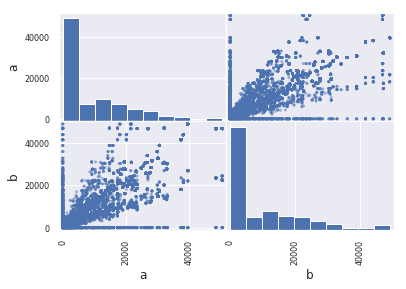

In [49]:
scatter_matrix(pd.DataFrame({'a':all_data['item_cnt_month_cat_lag_1'] +  all_data['item_cnt_month_cat_lag_2'],
             'b':all_data['item_cnt_month_cat_lag_3'] +  all_data['item_cnt_month_cat_lag_6']}).sample(20000))

In [11]:
#all_data['item_cnt_month_trend_1_2'] = all_data['item_cnt_month_lag_1'] - all_data['item_cnt_month_lag_2']
all_data['item_cnt_month_predict_1_2'] = all_data['item_cnt_month_lag_1']*2 - all_data['item_cnt_month_lag_2']
all_data['item_cnt_month_shop_predict_1_2'] = all_data['item_cnt_month_shop_lag_1']*2 - all_data['item_cnt_month_shop_lag_2']
all_data['item_cnt_month_cat_predict_1_2'] = all_data['item_cnt_month_cat_lag_1']*2 - all_data['item_cnt_month_cat_lag_2']

all_data['item_cnt_month_trend_3_6'] = all_data['item_cnt_month_lag_1'] + all_data['item_cnt_month_lag_2'] - all_data['item_cnt_month_lag_3'] - all_data['item_cnt_month_lag_6']
all_data['item_cnt_month_predict_3_6'] = (all_data['item_cnt_month_lag_1'] + all_data['item_cnt_month_lag_2'])*2 - all_data['item_cnt_month_lag_3'] - all_data['item_cnt_month_lag_6']
all_data['item_cnt_month_shop_trend_3_6'] = all_data['item_cnt_month_shop_lag_1'] + all_data['item_cnt_month_shop_lag_2'] - all_data['item_cnt_month_shop_lag_3'] - all_data['item_cnt_month_shop_lag_6']
all_data['item_cnt_month_shop_predict_3_6'] = (all_data['item_cnt_month_shop_lag_1'] + all_data['item_cnt_month_shop_lag_2'])*2 - all_data['item_cnt_month_shop_lag_3'] - all_data['item_cnt_month_shop_lag_6']
all_data['item_cnt_month_cat_trend_3_6'] = all_data['item_cnt_month_cat_lag_1'] + all_data['item_cnt_month_cat_lag_2'] - all_data['item_cnt_month_cat_lag_3'] - all_data['item_cnt_month_cat_lag_6']
all_data['item_cnt_month_cat_predict_3_6'] = (all_data['item_cnt_month_cat_lag_1'] + all_data['item_cnt_month_cat_lag_2'])*2 - all_data['item_cnt_month_cat_lag_3'] - all_data['item_cnt_month_cat_lag_6']

#all_data['item_cnt_month_item_trend_1_2'] = all_data['item_cnt_month_item_lag_1'] - all_data['item_cnt_month_item_lag_2']
all_data['item_cnt_month_item_trend_3_6'] = all_data['item_cnt_month_item_lag_1'] + all_data['item_cnt_month_item_lag_2'] - all_data['item_cnt_month_item_lag_3'] - all_data['item_cnt_month_item_lag_6']
#all_data['item_cnt_month_shop_trend_1_2'] = all_data['item_cnt_month_shop_lag_1'] - all_data['item_cnt_month_shop_lag_2']
all_data['item_cnt_month_shop_trend_3_6'] = all_data['item_cnt_month_shop_lag_1'] + all_data['item_cnt_month_shop_lag_2'] - all_data['item_cnt_month_shop_lag_3'] - all_data['item_cnt_month_shop_lag_6']
all_data['item_cnt_month_cat_trend_3_6'] = all_data['item_cnt_month_cat_lag_1'] + all_data['item_cnt_month_cat_lag_2'] - all_data['item_cnt_month_cat_lag_3'] - all_data['item_cnt_month_cat_lag_6']

In [12]:
all_data = pd.concat([all_data['ID'].astype(np.int32), downcast_dtypes(all_data.drop(columns='ID'))], axis=1)

# 5. Fit XGBoost<a id='5'></a>

In [2]:
with open('all_data4.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    all_data = pickle.load(f)

In [34]:
features = ['item_category_id', 'shop_city_label', 'date_block_num',
            'item_id_mean_enc', 'item_id_max_enc',
            'shop_id_mean_enc', 'shop_id_max_enc', 
            'shop_id_item_id_mean_enc', 'shop_id_item_id_max_enc',            
            'shop_id_item_category_id_mean_enc', 'shop_id_item_category_id_max_enc' ,

            'item_id', 'item_general_category_label', 
            'month', 'shop_id',
            
            'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
            'item_cnt_month_lag_12',
            'item_cnt_month_predict_1_2', 'item_cnt_month_predict_3_6',
            
            'item_cnt_month_cat_lag_1','item_cnt_month_cat_lag_2',
            'item_cnt_month_cat_lag_3', 'item_cnt_month_cat_lag_6', 'item_cnt_month_cat_lag_12', 
            
            'item_cnt_month_item_lag_1', 'item_cnt_month_item_lag_2', 'item_cnt_month_item_lag_3', 
            'item_cnt_month_item_lag_6', 'item_cnt_month_item_lag_12',
            'item_cnt_month_item_trend_1_2', 'item_cnt_month_item_trend_3_6', 
              
            'item_price_mean_lag_1', 'item_price_max_lag_1', 'item_price_mean_lag_2', 'item_price_max_lag_2',
            'item_price_mean_lag_3', 'item_price_max_lag_3', 'item_price_mean_lag_6', 'item_price_max_lag_6',
            'item_price_mean_lag_12', 'item_price_max_lag_12' ,
           
            'item_cnt_month_shop_lag_1', 'item_cnt_month_shop_lag_2', 'item_cnt_month_shop_lag_3',
            'item_cnt_month_shop_lag_6', 'item_cnt_month_shop_lag_12',
            'item_cnt_month_shop_trend_1_2', 'item_cnt_month_shop_trend_3_6',
            'item_cnt_month_trend_1_2', 'item_cnt_month_trend_3_6']

In [36]:
train_data = all_data[features + ['item_cnt_month']]

X_train = train_data.loc[train_data.date_block_num <= 32]
y_train = X_train['item_cnt_month']
X_train = X_train.drop(columns=['item_cnt_month'])

X_val = train_data.loc[train_data.date_block_num == 33]
y_val = X_val['item_cnt_month']
X_val = X_val.drop(columns=['item_cnt_month'])

X_test = train_data.loc[train_data.date_block_num == 34]

In [37]:
gc.collect()

3266

In [6]:
del all_data

In [38]:
ts = time.time()

xgb_model = XGBRegressor(
    tree_method='hist',
    max_depth=6, #8,
    n_estimators=1000,
    min_child_weight=100, #300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1, #0.3,    
    seed=42)

xgb_model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 5) #10

time.time() - ts #1.52 0.8

[12:18:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	validation_0-rmse:1.14715	validation_1-rmse:1.1091
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.09645	validation_1-rmse:1.06778
[2]	validation_0-rmse:1.05663	validation_1-rmse:1.0354
[3]	validation_0-rmse:1.01813	validation_1-rmse:1.00331
[4]	validation_0-rmse:0.98499	validation_1-rmse:0.97559
[5]	validation_0-rmse:0.958443	validation_1-rmse:0.953339
[6]	validation_0-rmse:0.9352	validation_1-rmse:0.934321
[7]	validation_0-rmse:0.913944	validation_1-rmse:0.917471
[8]	validation_0-rmse:0.897074	validation_1-rmse:0.907062
[9]	validation_0-rmse:0.881782	validation_1-rmse:0.895003
[10]	validation_0-rmse:0.869188	validation_1-rmse:0.883397
[11]	validation_0-rmse:0.858669	validation_1-rmse:0.875254
[12]	validation_0-rmse:0.848437	validation_1-rmse:0.868529
[

256.7015709877014

In [53]:
features[np.argmax(xgb_model.feature_importances_)], np.argmax(xgb_model.feature_importances_)

('item_cnt_month_item_lag_1', 30)

In [54]:
val = []
for idx, feat in enumerate(features):
#    print(feat, xgb_model.feature_importances_[idx])
    val.append(xgb_model.feature_importances_[idx])

In [55]:
print(pd.DataFrame([pd.Series(val), pd.Series(features)]).transpose().sort_values(by=0, ascending=False))

             0                                             1
30   0.0578512                     item_cnt_month_item_lag_1
3    0.0503931                                         month
11   0.0411207                            item_shop_duration
28   0.0399113                          item_cnt_month_lag_1
9    0.0356783                       item_last_sale_dbn_shop
19   0.0338641                      shop_id_item_id_mean_enc
2    0.0302358                                date_block_num
18   0.0284217                              item_id_mean_enc
51   0.0272123                 item_cnt_month_item_trend_1_2
23    0.024995             shop_id_item_category_id_mean_enc
52    0.023584                  item_cnt_month_cat_trend_1_2
24   0.0231808          item_general_category_label_mean_enc
34   0.0225761                          item_cnt_month_lag_2
56   0.0221729                 item_cnt_month_item_trend_1_3
8    0.0205604                         item_release_dbn_shop
1    0.0205604          

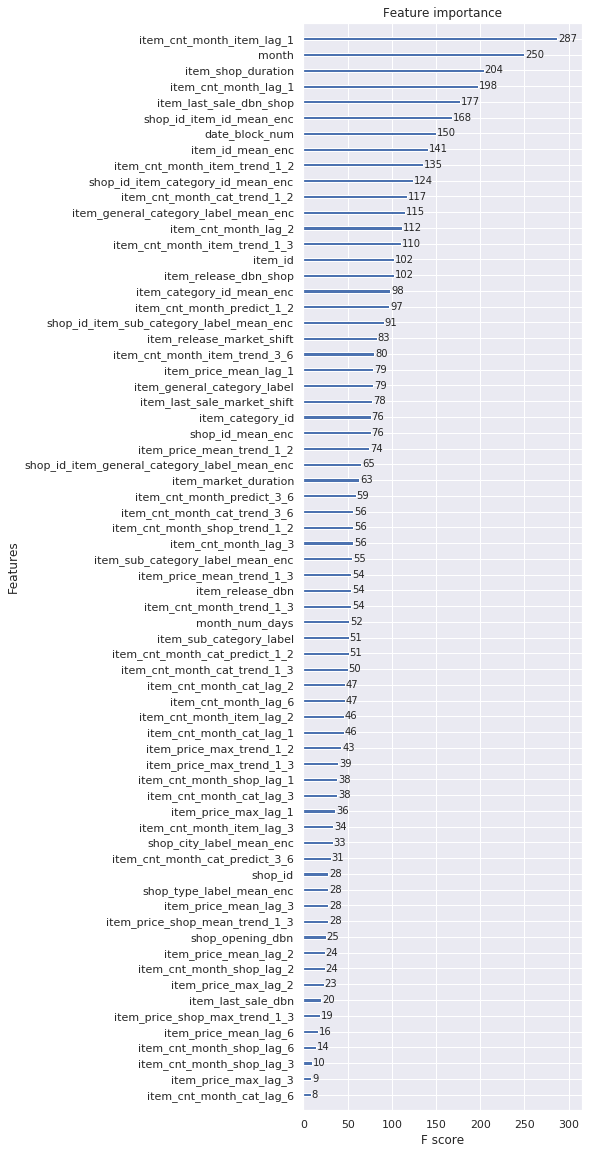

In [51]:
rcParams['figure.figsize'] = 5, 20
plot_importance(xgb_model, max_num_features=len(features))

In [43]:
X_test = X_test[features]
X_test['item_cnt_month']  =  xgb_model.predict(X_test).clip(0, 20)

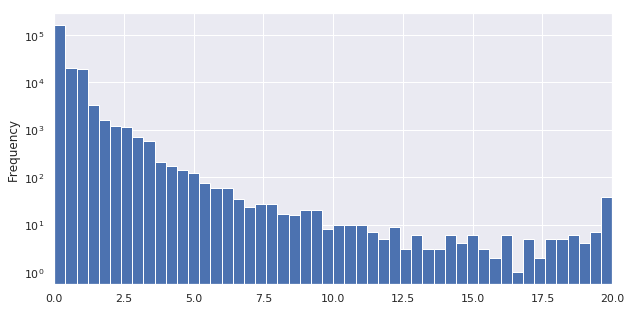

In [44]:
rcParams['figure.figsize'] = 10, 5

X_test['item_cnt_month'].plot.hist(bins=50, xlim=[0, 20], logy = True)

In [45]:
subm = pd.concat([all_data.loc[all_data.date_block_num == 34]['ID'].astype(np.int32), X_test.item_cnt_month], axis=1).sort_values('ID').reset_index(drop=True)
subm.to_csv('./submissions/subm_V167_xgb.csv', index=False)